# PairK examples - interpreting pairk conservation results

To help interpret pairk's results, I will use the `pairk.PairkConservation.plot_conservation_mosaic` method to plot the conservation scores and sequence logos of the "pseudo-MSAs" generated by pairk.

Here is an annotated example of the mosaic plot so that you can interpret each element of the plot

![annotated image](../images/mosaic_plot_annotated.png)

## background scores and z-scores

When assessing sequence conservation, it is important to ensure that observed conservation is from selection rather than a mere lack of divergence. For genes which evolve slowly, homologous sequences can appear highly similar or identical to each other merely because they haven't had enough time to diverge. In order to identify sequence elements that are conserved because they are important for function, the genes must have diverged enough for those important elements to stand out relative to the background sequence. A simple approach to account for background divergence is to cluster homologous sequences such that there is good background divergence across the homologs. Using a z-score is another option as it scores each position relative to the conservation of all other positions in the alignment.

Using z-scores is particularly important when interpreting the results from PairK regardless of the background divergence of the homologs. Sequence conservation from PairK is extra susceptible to over-estimation due to the fact that k-mer alignments contain less information than global alignments. For example, using k=2 will likely result in extremely high conservation scores due to the fact that the homologs have a high probability of having matching 2-mers by chance. In this case, the conservation score will be high and the sequence logo will look good, but the z-score will be low. Thus, conservation with pairk should not be interpreted by the sequence logos alone. PairK's plotting functions are included to help with interpretting the results of pairk. 

**TLDR: Use z-scores to interpret PairK results. conservation with pairk should not be interpreted by solely the sequence logos or raw conservation scores**

The below examples demonstrate these points and walk through the process of interpreting PairK results.

In [2]:
import pairk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Example 1: PairK with k=2

In [3]:
YLIMS = [-2, 2]
K = 2
POSITION = 7

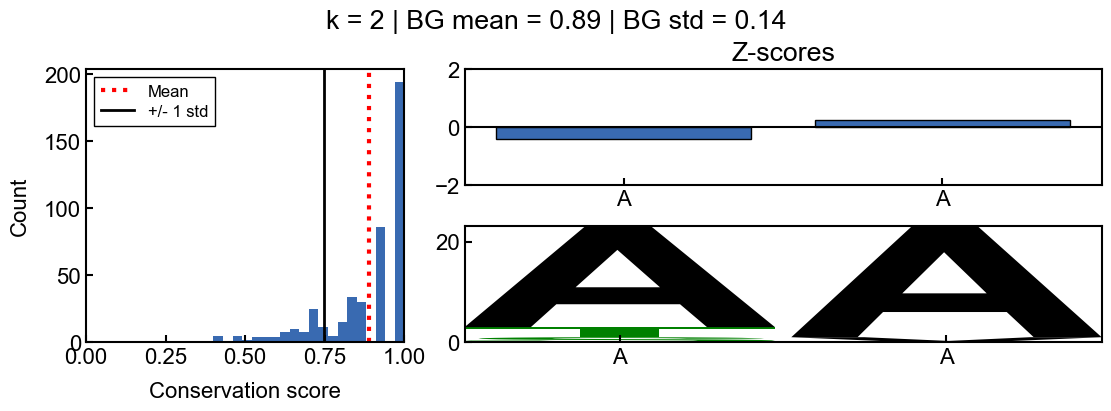

In [4]:
ex1 = pairk.example1
aln_results = pairk.pairk_alignment(
    idr_dict=ex1.idr_dict,
    query_id=ex1.query_id,
    k=K,
)
conservation_results = pairk.calculate_conservation(
    aln_results,
)
fig,axd=conservation_results.plot_conservation_mosaic(POSITION, score_type="z_score")
axd['scores'].set_ylim(YLIMS)
axd['scores'].set_title('Z-scores')
axd['scores'].axhline(0, color='black', linestyle='-')
_=fig.suptitle(f'k = {K} | BG mean = {conservation_results.bg_mean:.2f} | BG std = {conservation_results.bg_std:.2f}')

In this example, you can see that the sequence logo looks as if the sequence 'AA' is highly conserved, however this is likely just because most of the homologs have a matching 'AA' by chance. You can tell this by the z-scores, which indicate that the 'AA' sequence is not much more conserved than all of the other 2-mers in the query sequence and thus, the 'AA' should not be considered significantly conserved.

From the background score distribution (left) you can see that the conservation of all of the 2-mers is fairly high, which makes sense. Since the conservation scores are bounded between 0 and 1, a z-score above 1 is not even possible in this case since 1 standard deviation above the mean score is greater than 1. Thus the z-scores indirectly correct for when the background conservation is too high to be informative.

Also note that the z-scores are not normally distributed, so the z-score cutoffs are not as intuitive as they are for a normal distribution. However, they can still be interpreted as a measure of how many standard deviations a position is from the mean conservation score.

Without using z-scores, it would be easy to misinterpret the conservation of the 'AA' sequence as being significant, as seen in the plot below.

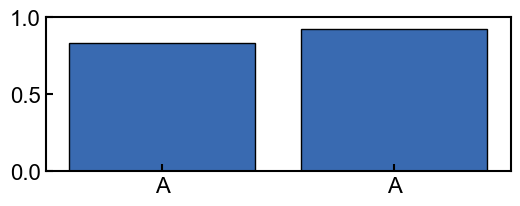

In [5]:
fig, ax = plt.subplots(figsize=(6,2))
_=conservation_results.plot_score_barplot(POSITION, score_type="score", ax=ax)
_=ax.set_ylim([0, 1])

### Example 2: PairK with k=6

In [6]:
YLIMS = [-2, 2]
K = 6
POSITION = 7

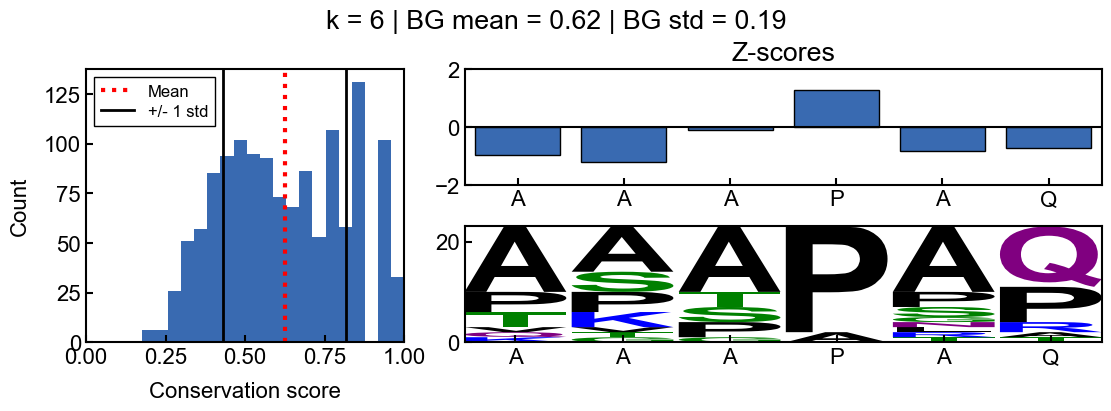

In [7]:
def gen_mosaic(k, position):
    aln_results = pairk.pairk_alignment(
        idr_dict=ex1.idr_dict,
        query_id=ex1.query_id,
        k=k,
    )
    conservation_results = pairk.calculate_conservation(
        aln_results,
    )
    fig,axd=conservation_results.plot_conservation_mosaic(position, score_type="z_score")
    axd['scores'].set_ylim(YLIMS)
    axd['scores'].set_title('Z-scores')
    axd['scores'].axhline(0, color='black', linestyle='-')
    _=fig.suptitle(f'k = {k} | BG mean = {conservation_results.bg_mean:.2f} | BG std = {conservation_results.bg_std:.2f}')
    return conservation_results

_=gen_mosaic(K, POSITION)

When k=6, the background conservation is lower, and there is more conservation signal. In this case, the 'AAAPAQ' sequence is not significantly conserved (except the 'P'), as indicated by the z-scores. This time, the sequence logo also reflects the lack of relative conservation.

Here is a k-mer that is conserved relative to the rest of the idr

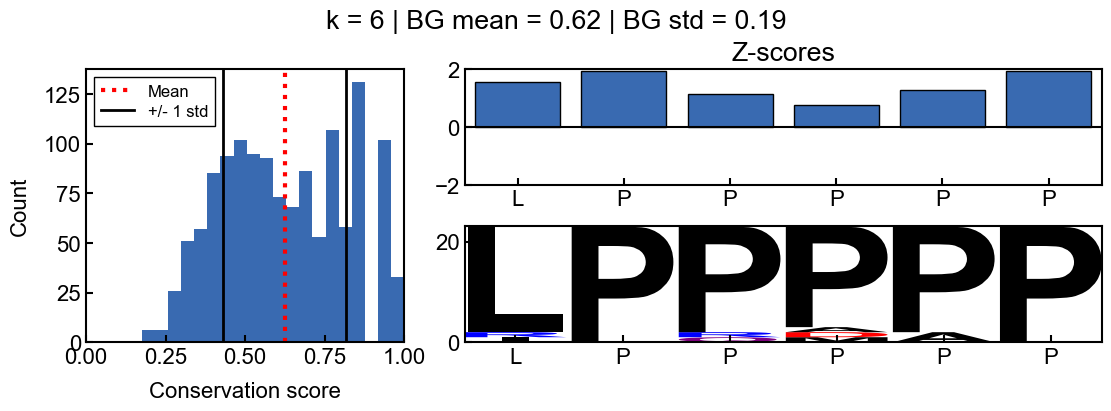

In [8]:
_=gen_mosaic(k=6, position=75)

You can see how the scores change with different values for k

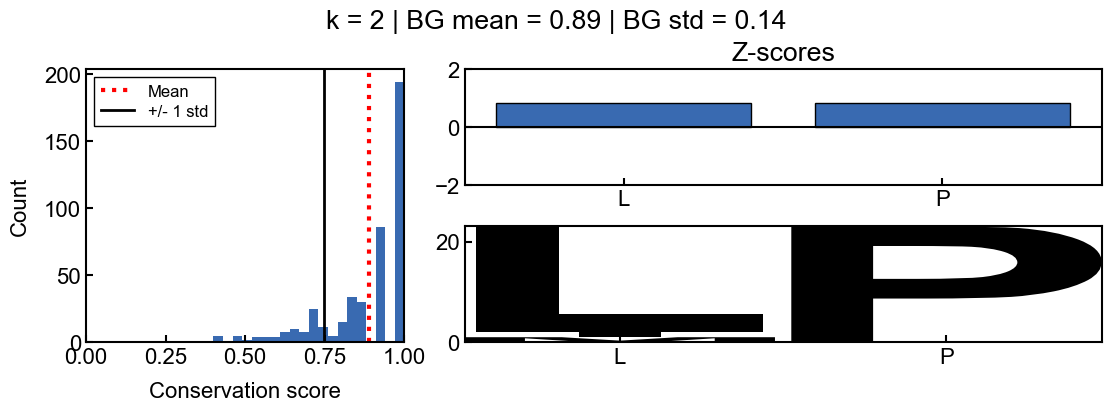

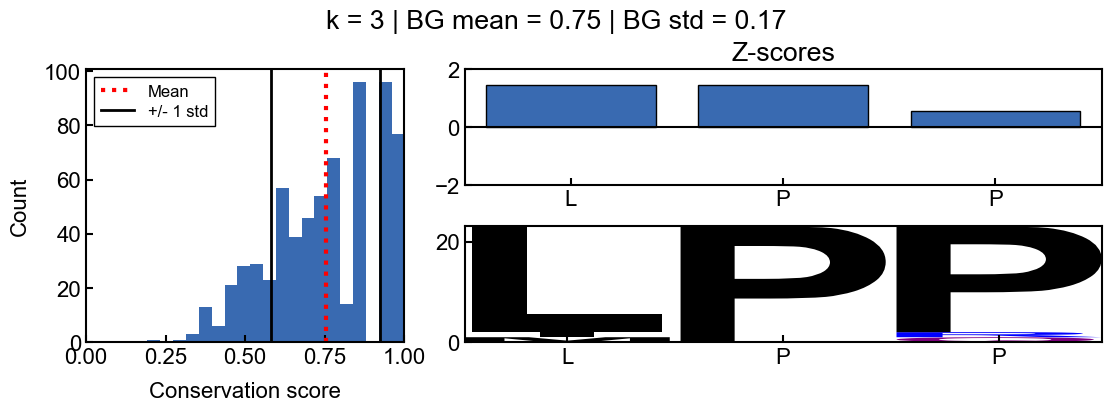

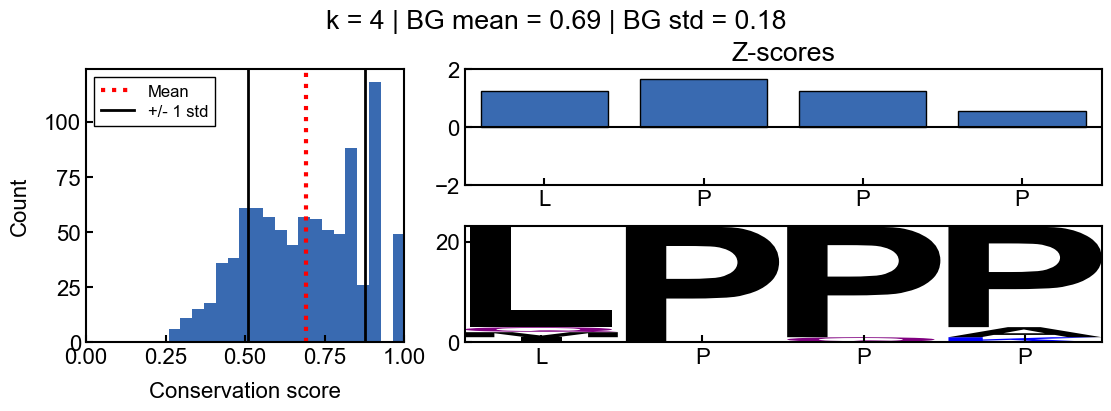

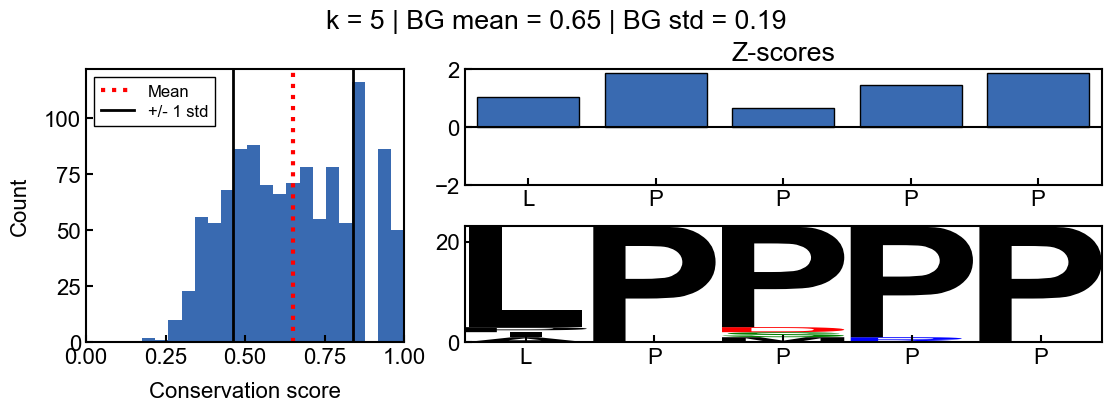

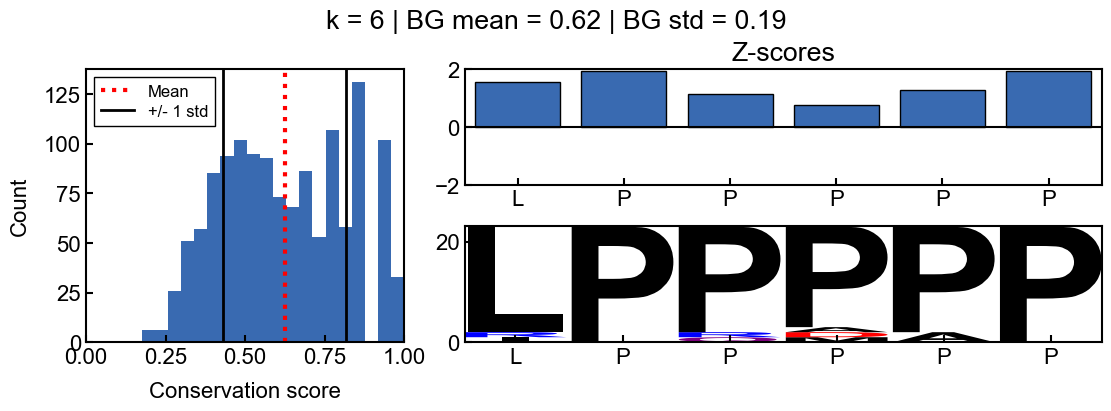

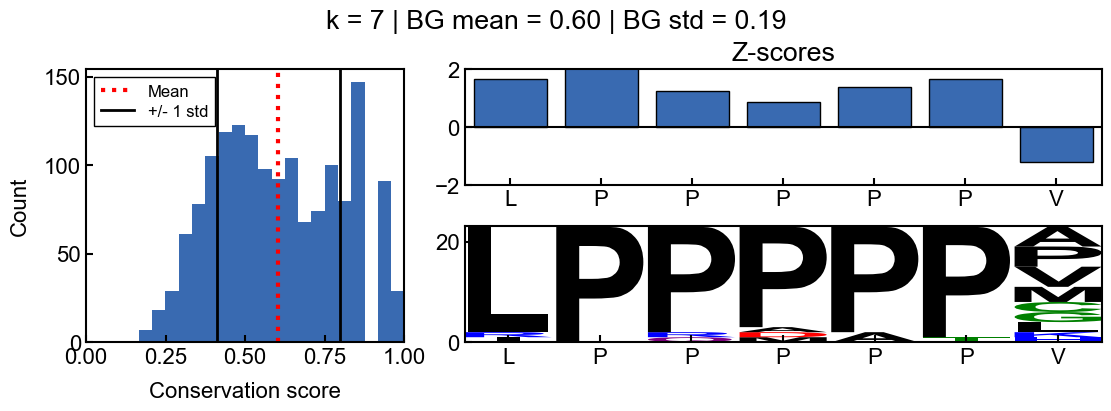

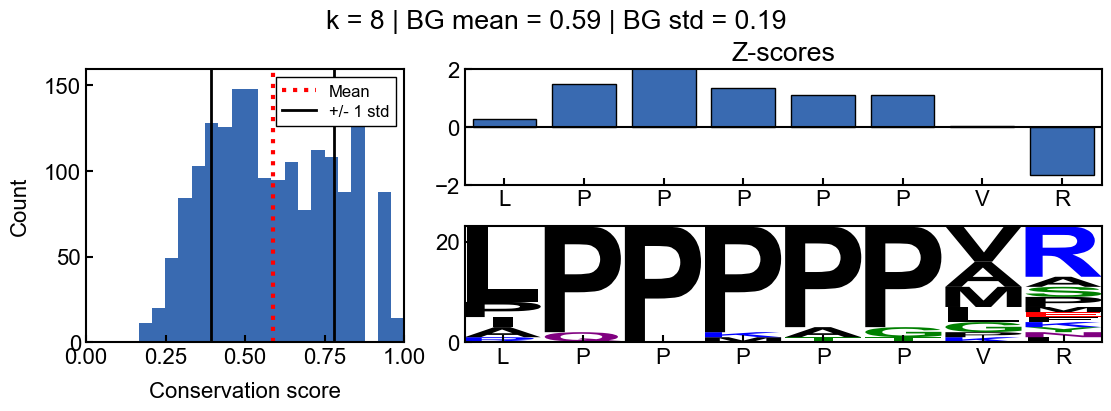

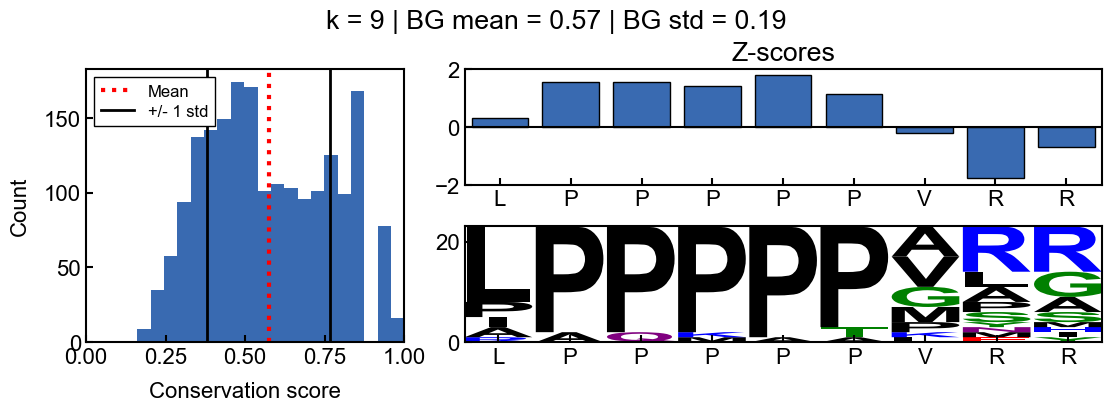

In [9]:
for i in range(2, 10):
    _=gen_mosaic(k=i, position=75)

## background score standard deviation

Z-scores are more difficult to interpret when the background scores are all extremely similar and the score distribution is extremely narrow. The resulting z-scores are more susceptible to outliers. Thus I would recommend using a standard deviation filter to avoid associated artifacts. In the pairk benchmark, I required conservation scores to have a background score standard deviation greater than 0.05. The background standard deviation is stored in the `pairk.PairkConservation.bg_std` attribute and can be used to filter out conservation scores with a low standard deviation.

Similarly, z-scores are more reliable when the background score distribution is well determined. There should be enough background scores to calculate the standard deviation and mean values well. Thus I would suggest requiring a minimum number of background scores. In the pairk benchmark, I required there to be at least 50 background scores. The number of points in the background distribution is stored in the `pairk.PairkConservation.n_bg_scores` attribute and can be used to filter.

Similarly, you might not want the background distribution to be composed of scores from only a few k-mer pseudo-MSAs. In the pairk benchmark, I required there to be at least 10 unique k-mers used. The number of unique k-mers used to calculate scores is stored in the `pairk.PairkConservation.n_bg_kmers` attribute and can be used to filter.

### Example 3: PairK with k=1

In special cases, the z-scores can be misleading when they are not well determined. This happens when there are not enough background scores or when the standard deviation of background scores is too small. In unusual cases, like when k=1, the z-scores can appear artificially high because there is a low standard deviation. The z-scores are not reliable in this case and should not be used to interpret the conservation scores.

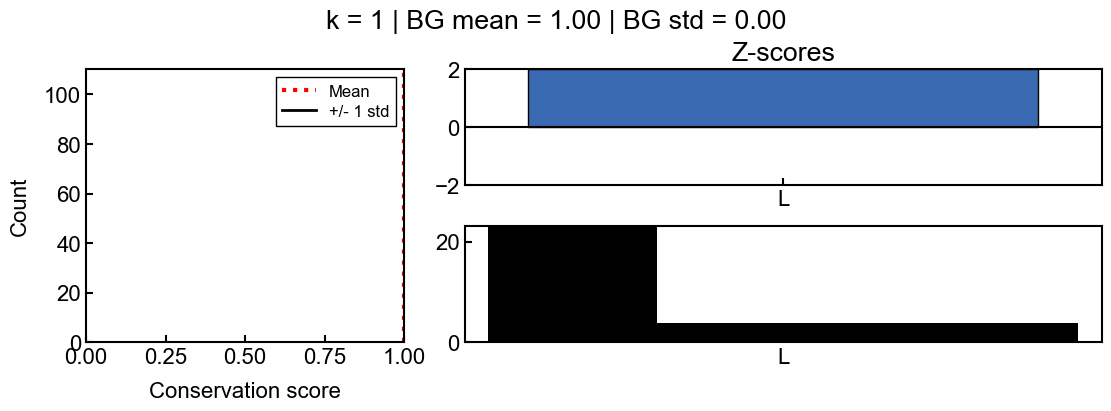

In [10]:
conservation_results=gen_mosaic(k=1, position=75)

In this case, the background score standard deviation is 0.0, which means that the z-scores are not reliable

In this case, all of the k-mers have a conservation score of almost 1.0, however, there are tiny differences in the values (e.g. 0.9999993 vs 0.99999937), resulting in very high or low z-scores.

In [11]:
print(f'number of background scores {conservation_results.n_bg_scores}')
print(f'background score standard deviation {conservation_results.bg_std}')

number of background scores 226
background score standard deviation 3.2741953144864496e-08
